In [1]:
import os
import sys
import warnings

import pdb

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn import tree

from utils import MySet

from utils import local_data
from utils import window
from utils import Scale, give_error
from utils import generate_and_avaliate_model

from utils import location_station, find_set_sunrise, find_set_sunset

%matplotlib inline
warnings.filterwarnings('ignore')

latter_size = 14
plt.rcParams['legend.fontsize'] = latter_size 
plt.rcParams['font.size'] = latter_size 
plt.rcParams['axes.labelsize'] = latter_size
plt.rcParams['xtick.labelsize'] = latter_size
plt.rcParams['ytick.labelsize'] = latter_size

In [2]:
df = pd.read_pickle('./data/sj2_analise_update.pkl')

In [3]:
df.columns

Index(['vtec', 'vtec_dt', 'vtec_dt2', 'gvtec1', 'gvtec1_dt', 'gvtec2',
       'gvtec2_dt', 'state_night', 'state_dawn', 'vm1', 'vd1', 'vm2', 'vd2',
       'gvtec1_dt_lag_9', 'gvtec2_dt_lag_20', 'vtec_dt_lag_3', 's4'],
      dtype='object')

In [4]:
original = MySet('original', ['vtec', 'vtec_dt', 'vtec_dt2', 'gvtec1', 'gvtec1_dt', 'gvtec2', 'gvtec2_dt'])
tempo  = MySet('tempo', ['state_night', 'state_dawn'])
mdv1 = MySet('mdv1', ['vm1', 'vd1'])
mdv2 = MySet('mdv2', ['vm2', 'vd2'])
lag = MySet('lag', ['gvtec1_dt_lag_9', 'gvtec2_dt_lag_20'])

vtec = MySet('vtec', ['vtec'])
vtec_dt = MySet('vtec_dt', ['vtec_dt'])
vtec_dt2 = MySet('vtec_dt2', ['vtec_dt2'])
gvtec1 = MySet('gvtec1', ['gvtec1'])
gvtec1_dt = MySet('gvtec1_dt', ['gvtec1_dt'])
gvtec2 = MySet('gvtec2', ['gvtec2'])
gvtec2_dt = MySet('gvtec2_dt', ['gvtec2_dt'])
state_night = MySet('state_night', ['state_night'])
state_dawn = MySet('state_dawn', ['state_dawn'])
vm1 = MySet('vm1', ['vm1'])
vd1 = MySet('vd1', ['vd1'])
vm2 = MySet('vm2', ['vm2'])
vd2 = MySet('vd2', ['vd2'])
gvtec1_dt_lag_9 = MySet('gvtec1_dt_lag_9', ['gvtec1_dt_lag_9'])
gvtec2_dt_lag_20 = MySet('gvtec2_dt_lag_20', ['gvtec2_dt_lag_20'])

In [5]:
set_tests = [original,
             original-vtec,
             original-vtec_dt,
             original-gvtec1,
             original-gvtec1_dt,
             original-gvtec2,
             original-gvtec2_dt,
             original+tempo,
             original+gvtec1_dt_lag_9,
             original+gvtec2_dt_lag_20,
             original+lag,
             original+mdv1,
             original+mdv2,
             original+tempo+lag,
             original+tempo+mdv2,
             original+tempo+mdv2+lag,
             original+tempo+lag+mdv1+mdv2,
             vtec,
             vtec+gvtec1_dt_lag_9,
             vtec+gvtec2_dt_lag_20,
             vtec+vtec_dt+vtec_dt2,
             vtec+gvtec1+gvtec2,
             vtec+tempo,
             vtec+tempo+mdv1,
             vtec+tempo+lag,
             vtec+tempo+lag+mdv1,
             vtec+tempo+lag+mdv2,
             vtec+tempo+lag+mdv1+mdv2]

In [6]:
param_grid = True

0  ->  original
Error for the time series sample:
acc             0.868384
f1              0.535884
far             0.391263
fn             46.100000
fp             28.000000
kappa           0.068740
me              0.348440
mse             0.004291
pod             0.482022
precission      0.608737
re             23.649727
recall          0.482022
tn            446.000000
tp             42.900000
tse             1.553984
dtype: float64


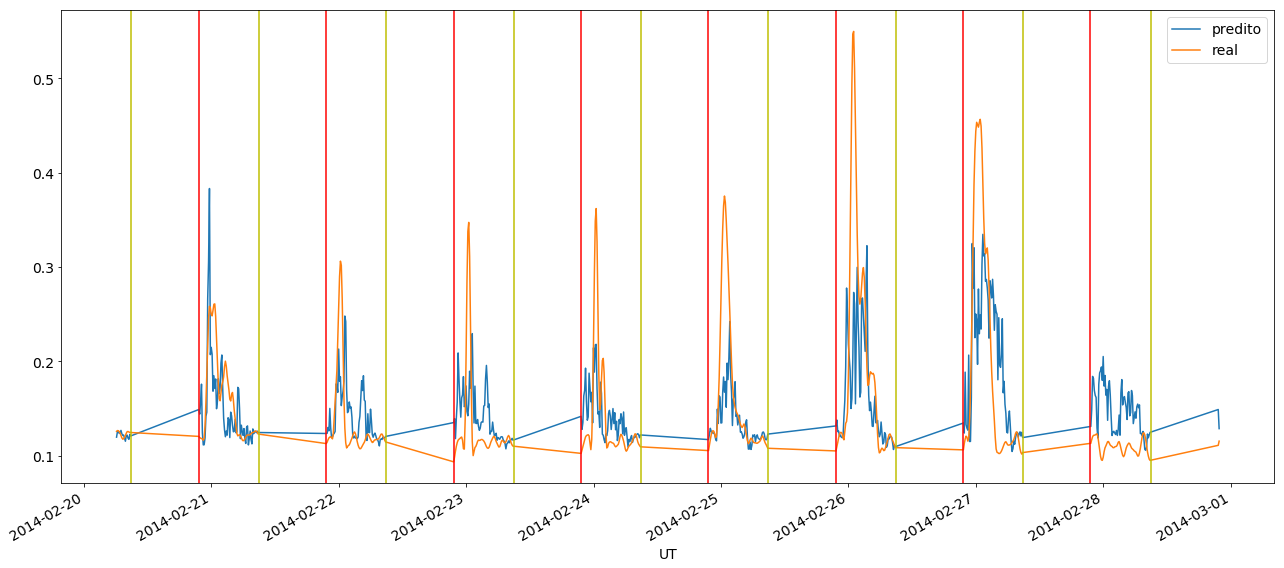


1  ->  original - vtec
Error for the time series sample:
acc             0.833037
f1              0.540635
far             0.520628
fn             33.700000
fp             60.300000
kappa           0.054452
me              0.330296
mse             0.004929
pod             0.621348
precission      0.479372
re             30.831003
recall          0.621348
tn            413.700000
tp             55.300000
tse             1.664415
dtype: float64


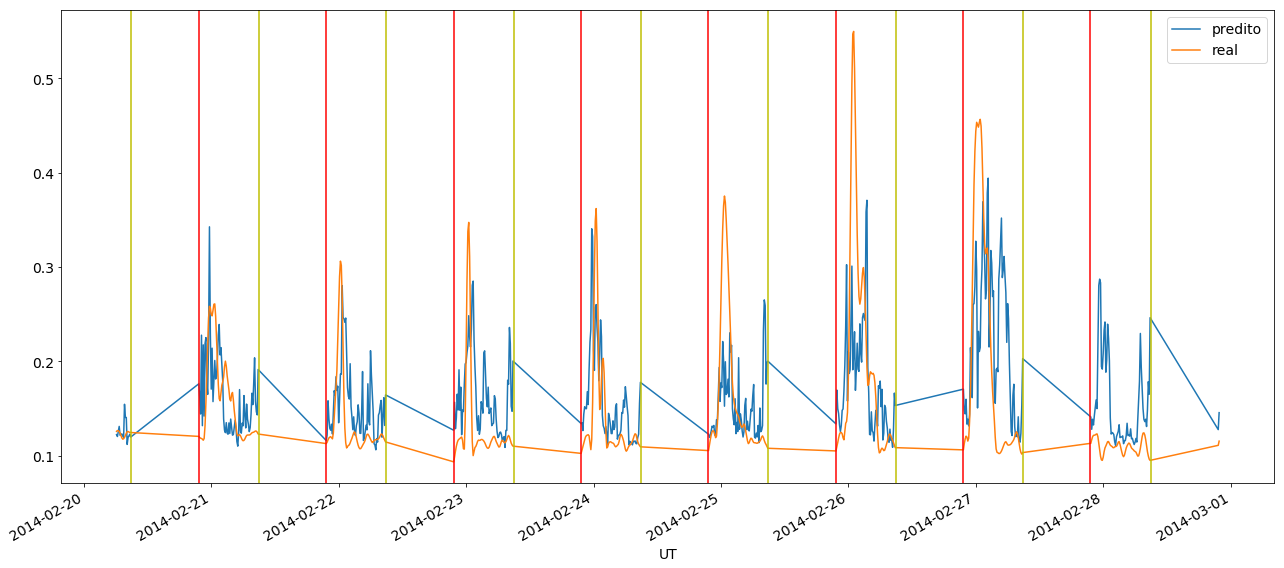


2  ->  original - vtec_dt
Error for the time series sample:
acc             0.861456
f1              0.518587
far             0.422225
fn             46.900000
fp             31.100000
kappa           0.069747
me              0.348178
mse             0.004566
pod             0.473034
precission      0.577775
re             24.021075
recall          0.473034
tn            442.900000
tp             42.100000
tse             1.603002
dtype: float64


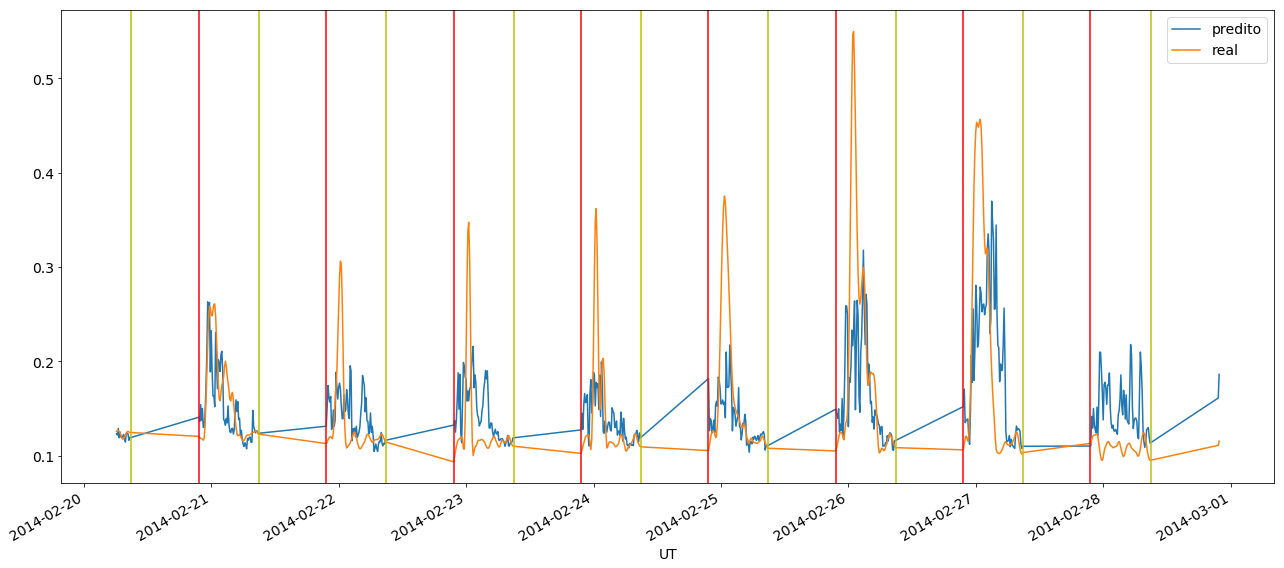


3  ->  original - gvtec1
Error for the time series sample:
acc             0.866785
f1              0.524746
far             0.395445
fn             47.600000
fp             27.400000
kappa           0.070681
me              0.342258
mse             0.004423
pod             0.465169
precission      0.604555
re             24.117583
recall          0.465169
tn            446.600000
tp             41.400000
tse             1.577870
dtype: float64


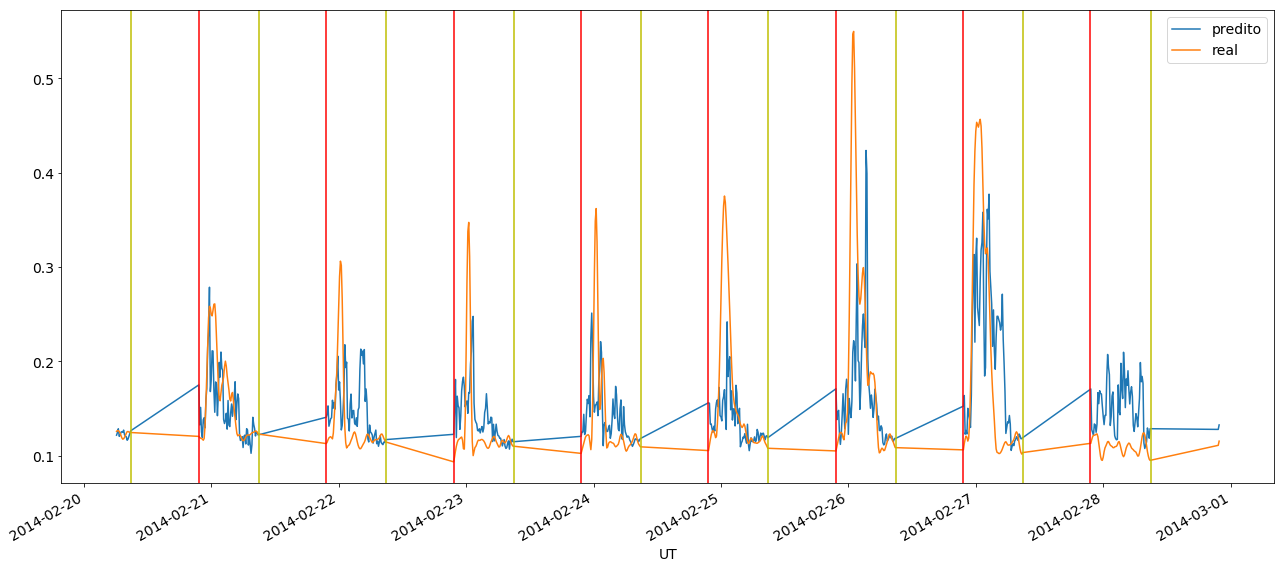


4  ->  original - gvtec1_dt
Error for the time series sample:
acc             0.861812
f1              0.489282
far             0.408662
fn             51.600000
fp             26.200000
kappa           0.076066
me              0.366204
mse             0.004369
pod             0.420225
precission      0.591338
re             22.604091
recall          0.420225
tn            447.800000
tp             37.400000
tse             1.568129
dtype: float64


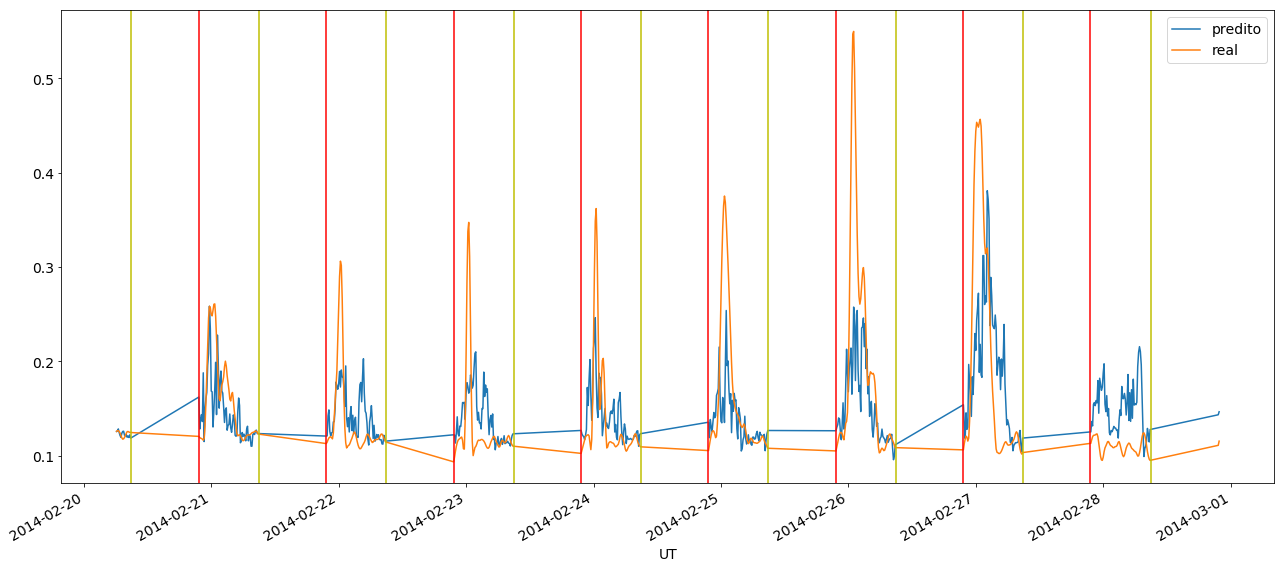


5  ->  original - gvtec2
Error for the time series sample:
acc             0.815631
f1              0.503778
far             0.560959
fn             36.300000
fp             67.500000
kappa           0.057791
me              0.345407
mse             0.005187
pod             0.592135
precission      0.439041
re             31.134489
recall          0.592135
tn            406.500000
tp             52.700000
tse             1.708401
dtype: float64


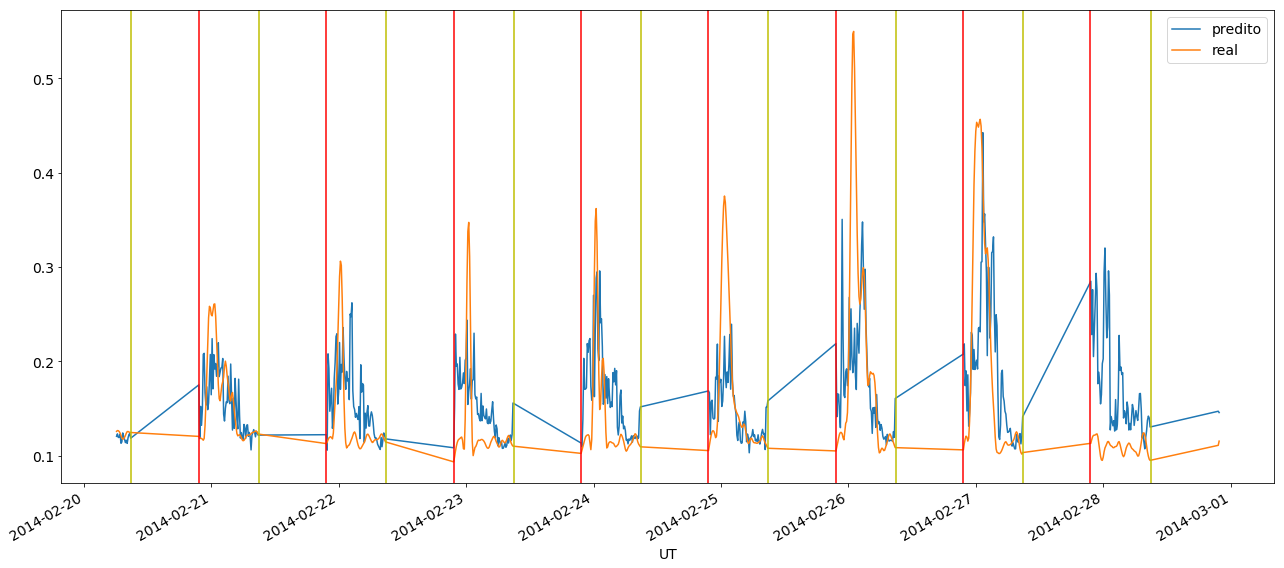


6  ->  original - gvtec2_dt
Error for the time series sample:
acc             0.857371
f1              0.513569
far             0.441213
fn             46.600000
fp             33.700000
kappa           0.069256
me              0.368908
mse             0.004566
pod             0.476404
precission      0.558787
re             24.487359
recall          0.476404
tn            440.300000
tp             42.400000
tse             1.602838
dtype: float64


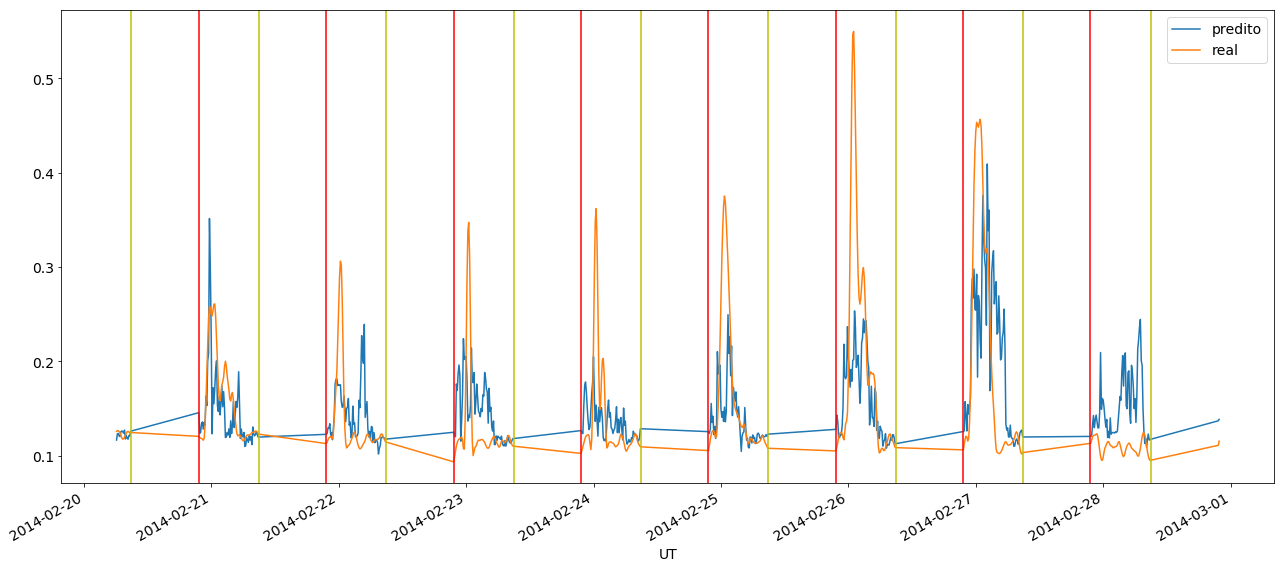


7  ->  original + tempo
Error for the time series sample:
acc             0.871403
f1              0.582259
far             0.400226
fn             38.400000
fp             34.000000
kappa           0.058750
me              0.349226
mse             0.004084
pod             0.568539
precission      0.599774
re             23.895986
recall          0.568539
tn            440.000000
tp             50.600000
tse             1.515911
dtype: float64


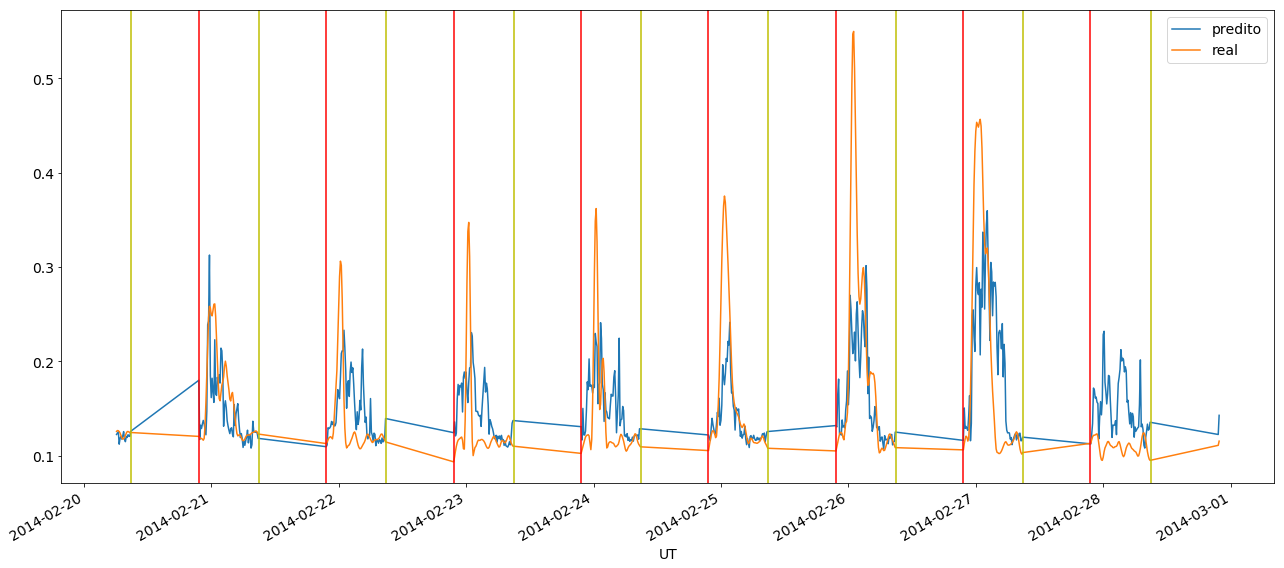


8  ->  original + gvtec1_dt_lag_9
Error for the time series sample:
acc             0.876732
f1              0.597282
far             0.379346
fn             37.600000
fp             31.800000
kappa           0.057637
me              0.347407
mse             0.004084
pod             0.577528
precission      0.620654
re             23.704918
recall          0.577528
tn            442.200000
tp             51.400000
tse             1.515921
dtype: float64


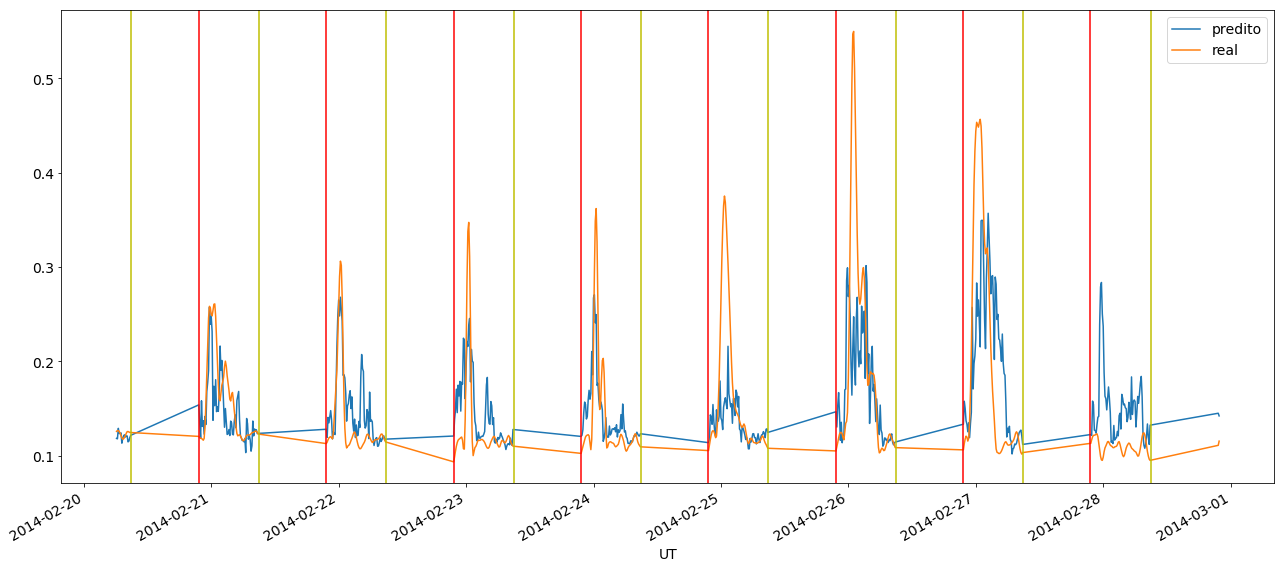


9  ->  original + gvtec2_dt_lag_20
Error for the time series sample:
acc             0.860213
f1              0.541336
far             0.432515
fn             42.200000
fp             36.500000
kappa           0.063895
me              0.350601
mse             0.004194
pod             0.525843
precission      0.567485
re             24.326305
recall          0.525843
tn            437.500000
tp             46.800000
tse             1.534991
dtype: float64


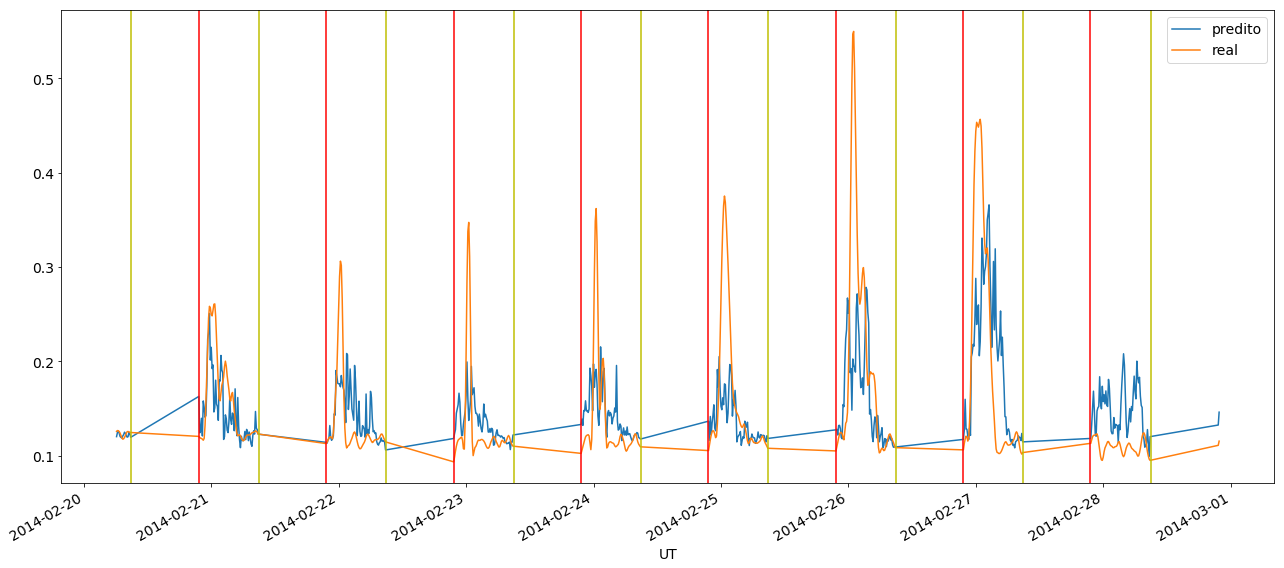


10  ->  original + lag
Error for the time series sample:
acc             0.868206
f1              0.601046
far             0.422857
fn             33.100000
fp             41.100000
kappa           0.052465
me              0.344137
mse             0.004124
pod             0.628090
precission      0.577143
re             24.843538
recall          0.628090
tn            432.900000
tp             55.900000
tse             1.523301
dtype: float64


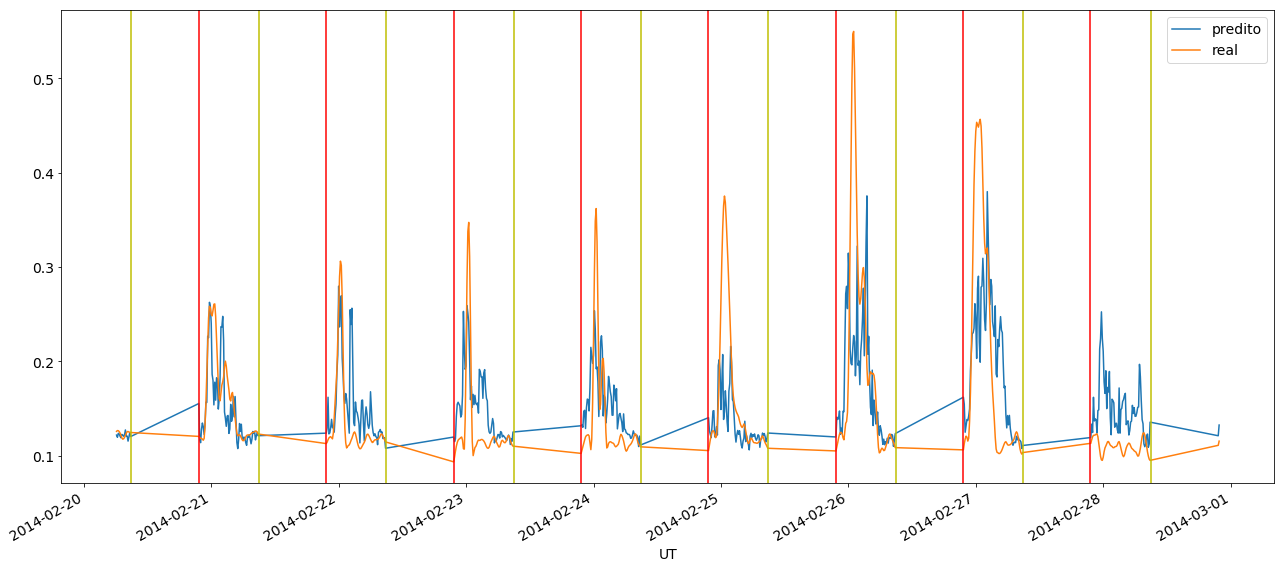


11  ->  original + mdv1
Error for the time series sample:
acc             0.836057
f1              0.578688
far             0.508455
fn             25.900000
fp             66.400000
kappa           0.046688
me              0.330386
mse             0.004484
pod             0.708989
precission      0.491545
re             28.734930
recall          0.708989
tn            407.600000
tp             63.100000
tse             1.588017
dtype: float64


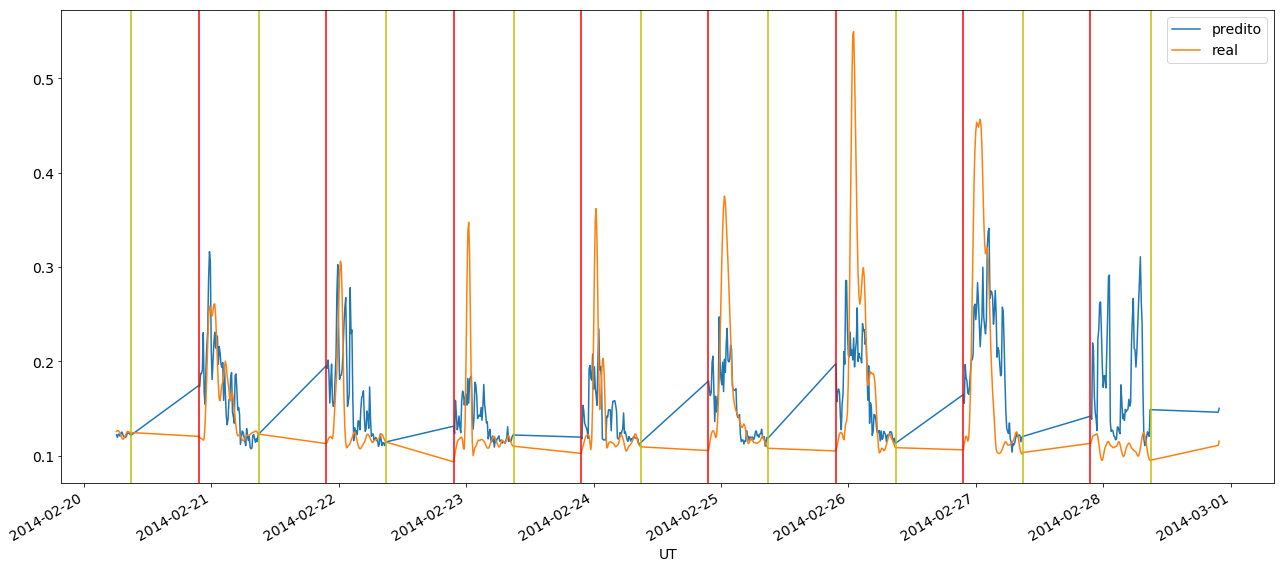


12  ->  original + mdv2
Error for the time series sample:
acc             0.854352
f1              0.510773
far             0.449947
fn             46.200000
fp             35.800000
kappa           0.068750
me              0.360895
mse             0.004483
pod             0.480899
precission      0.550053
re             26.228632
recall          0.480899
tn            438.200000
tp             42.800000
tse             1.588014
dtype: float64


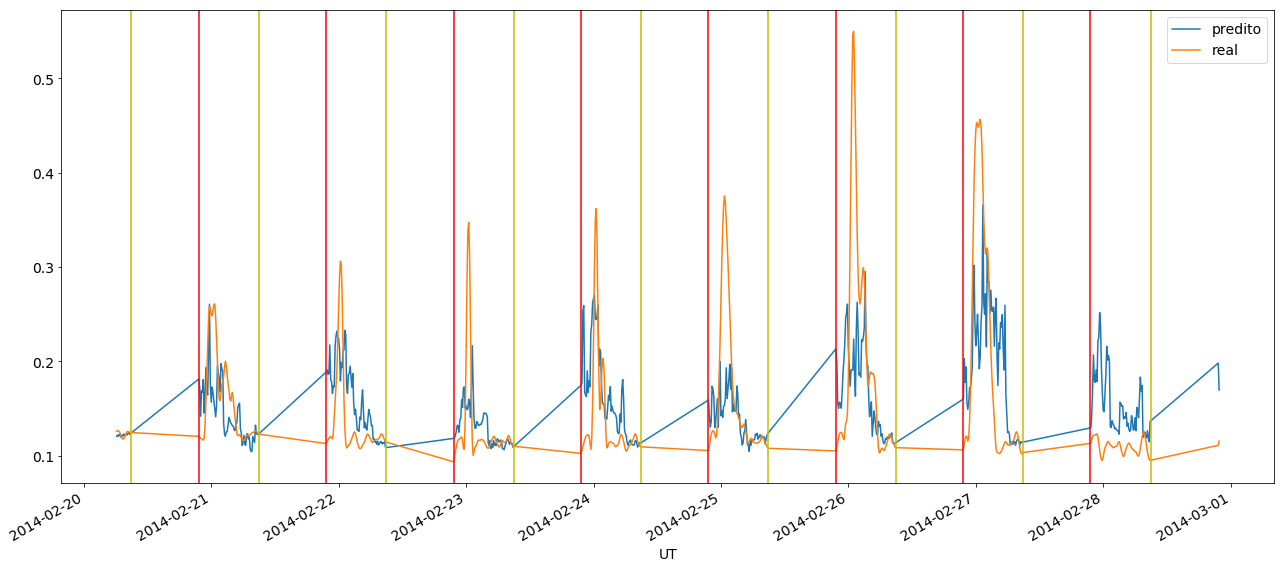


13  ->  original + tempo + lag
Error for the time series sample:
acc             0.880639
f1              0.618395
far             0.375193
fn             34.400000
fp             32.800000
kappa           0.053555
me              0.357945
mse             0.003927
pod             0.613483
precission      0.624807
re             23.045673
recall          0.613483
tn            441.200000
tp             54.600000
tse             1.486313
dtype: float64


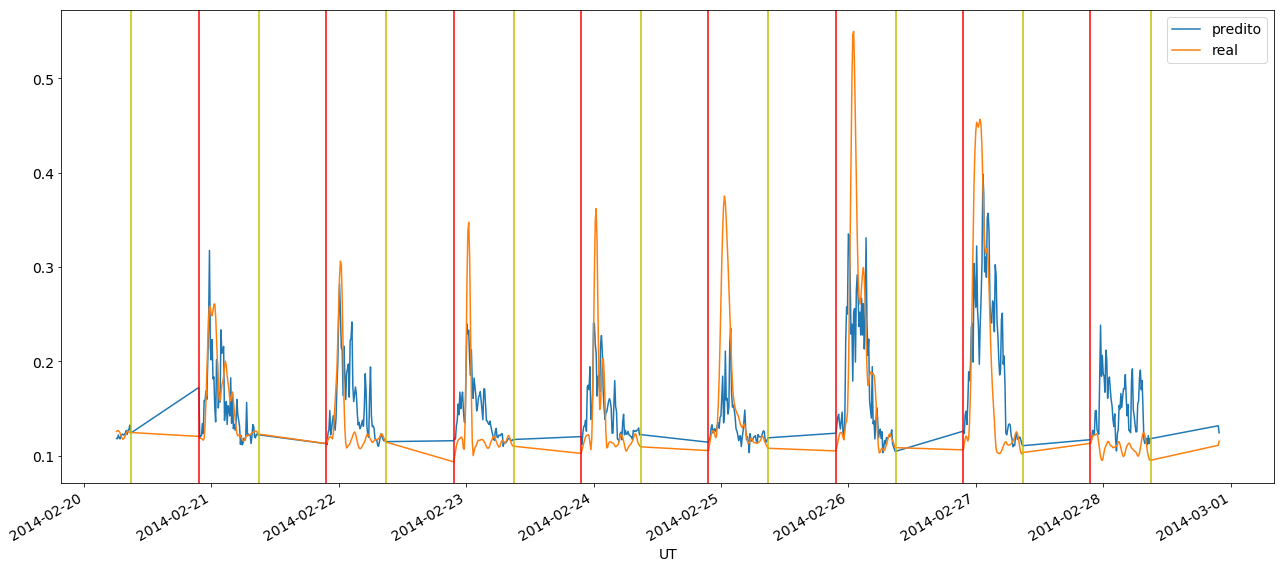


14  ->  original + tempo + mdv2
Error for the time series sample:
acc             0.871581
f1              0.592840
far             0.404996
fn             35.900000
fp             36.400000
kappa           0.055852
me              0.339660
mse             0.004182
pod             0.596629
precission      0.595004
re             25.315297
recall          0.596629
tn            437.600000
tp             53.100000
tse             1.534308
dtype: float64


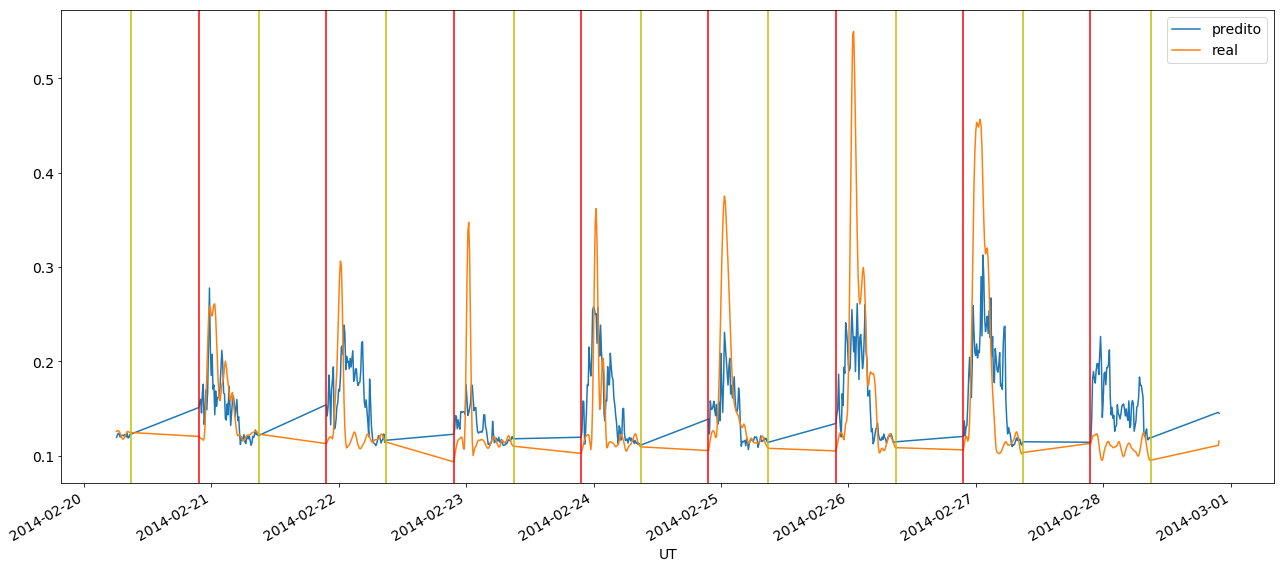


15  ->  original + tempo + mdv2 + lag
Error for the time series sample:
acc             0.869094
f1              0.608908
far             0.422701
fn             31.600000
fp             42.100000
kappa           0.050551
me              0.330215
mse             0.003959
pod             0.644944
precission      0.577299
re             25.016966
recall          0.644944
tn            431.900000
tp             57.400000
tse             1.491690
dtype: float64


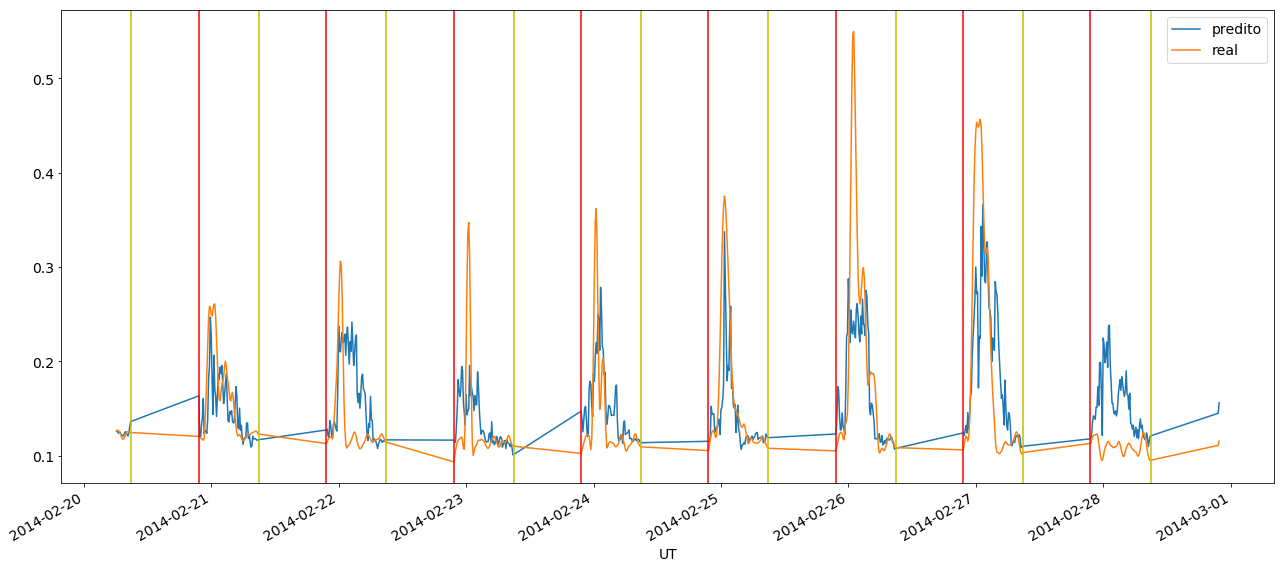


16  ->  original + tempo + lag + mdv1 + mdv2
Error for the time series sample:
acc             0.846536
f1              0.595543
far             0.487682
fn             25.500000
fp             60.900000
kappa           0.045407
me              0.338060
mse             0.004258
pod             0.713483
precission      0.512318
re             28.050519
recall          0.713483
tn            413.100000
tp             63.500000
tse             1.547425
dtype: float64


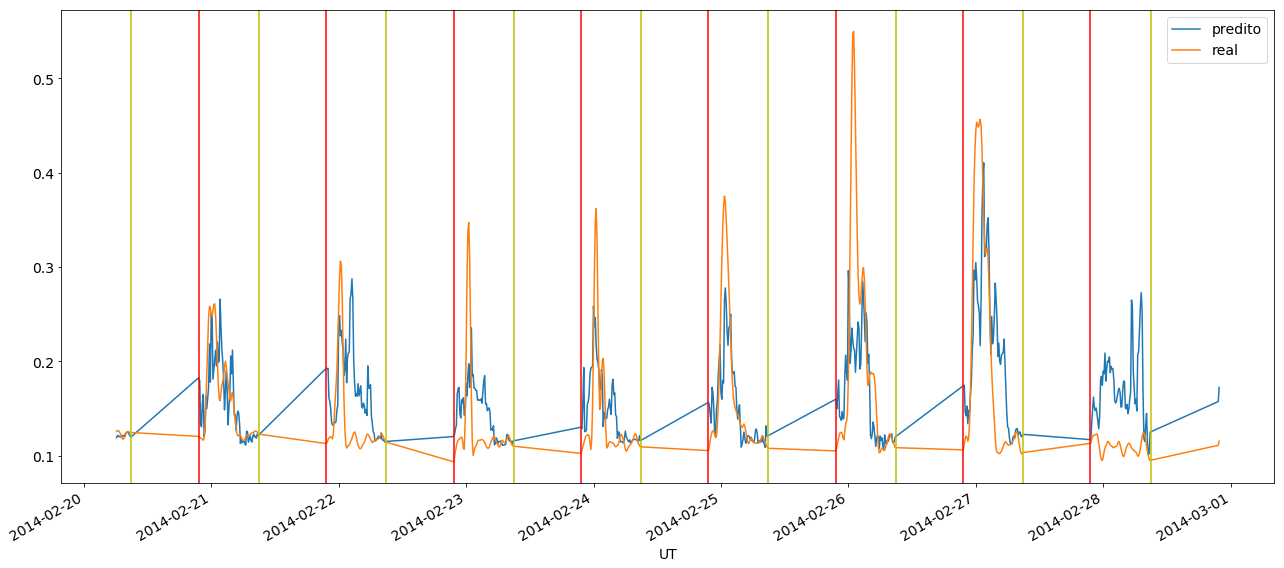


17  ->  vtec
Error for the time series sample:
acc             0.785080
f1              0.263788
far             0.712336
fn             67.300000
fp             53.700000
kappa           0.092892
me              0.393490
mse             0.007068
pod             0.243820
precission      0.287664
re             30.096523
recall          0.243820
tn            420.300000
tp             21.700000
tse             1.994595
dtype: float64


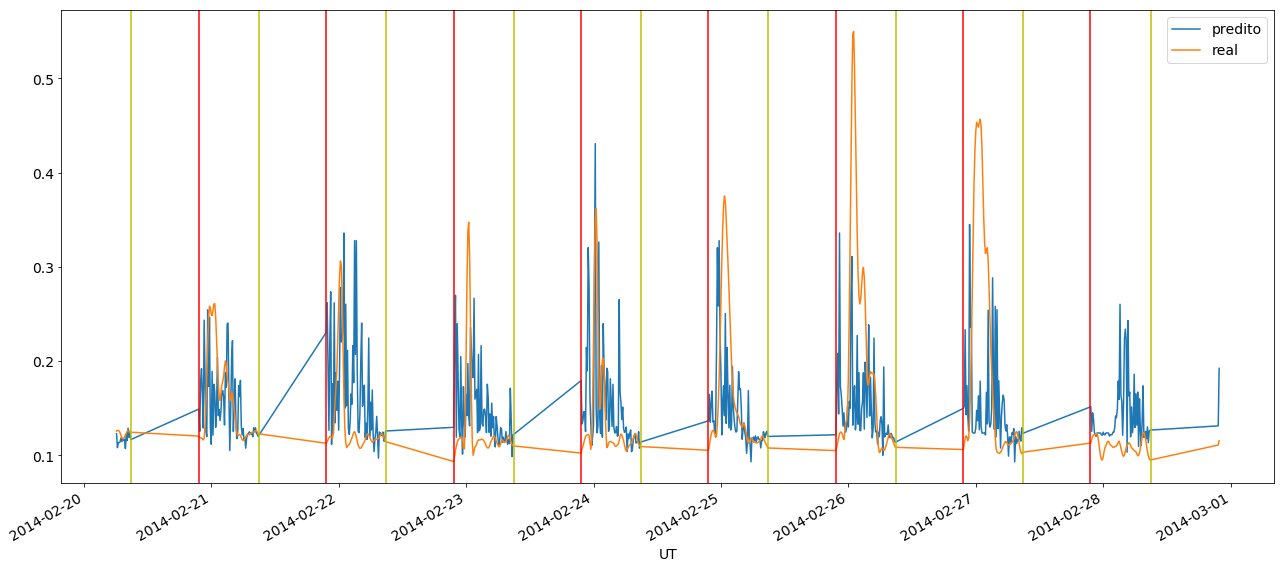


18  ->  vtec + gvtec1_dt_lag_9
Error for the time series sample:
acc             0.805861
f1              0.498547
far             0.578828
fn             34.600000
fp             74.700000
kappa           0.056398
me              0.345478
mse             0.006148
pod             0.611236
precission      0.421172
re             35.137256
recall          0.611236
tn            399.300000
tp             54.400000
tse             1.860203
dtype: float64


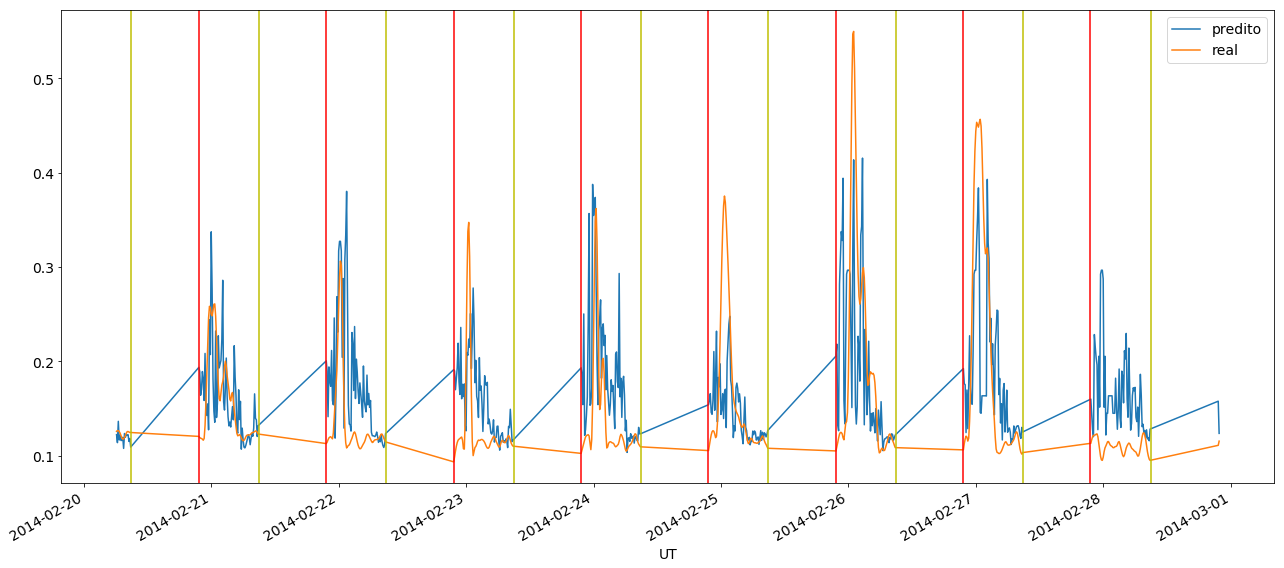


19  ->  vtec + gvtec2_dt_lag_20
Error for the time series sample:
acc             0.829307
f1              0.476627
far             0.537189
fn             45.200000
fp             50.900000
kappa           0.067399
me              0.321026
mse             0.004551
pod             0.492135
precission      0.462811
re             26.924678
recall          0.492135
tn            423.100000
tp             43.800000
tse             1.600439
dtype: float64


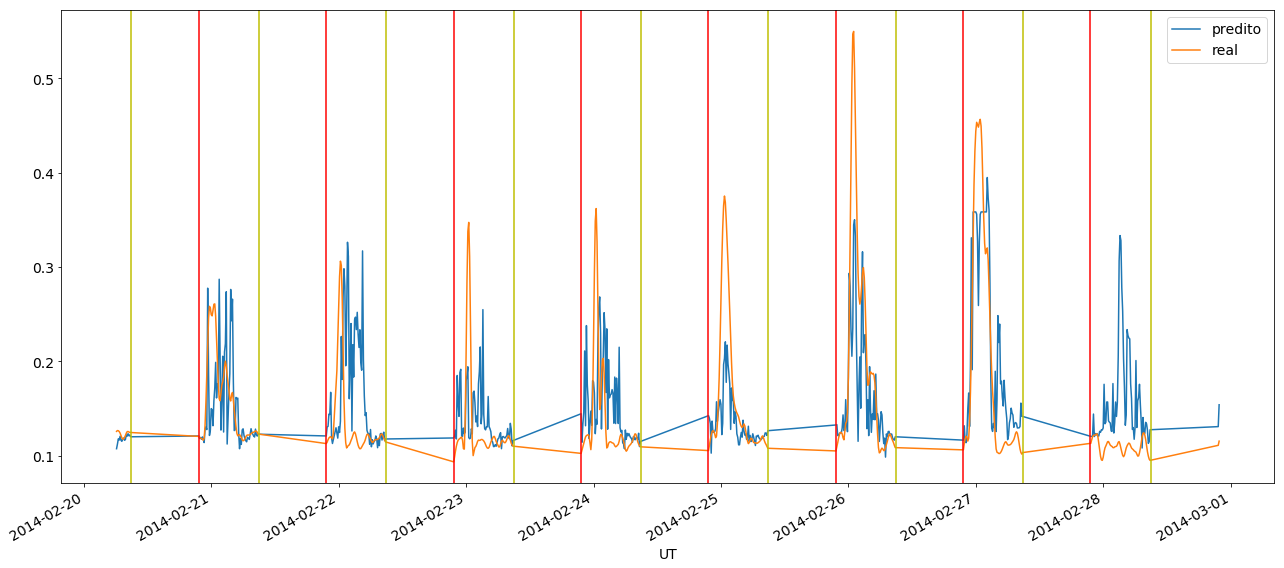


20  ->  vtec + vtec_dt + vtec_dt2
Error for the time series sample:
acc             0.833393
f1              0.540495
far             0.520169
fn             33.800000
fp             60.000000
kappa           0.054637
me              0.332345
mse             0.005627
pod             0.620225
precission      0.479831
re             31.479041
recall          0.620225
tn            414.000000
tp             55.200000
tse             1.778678
dtype: float64


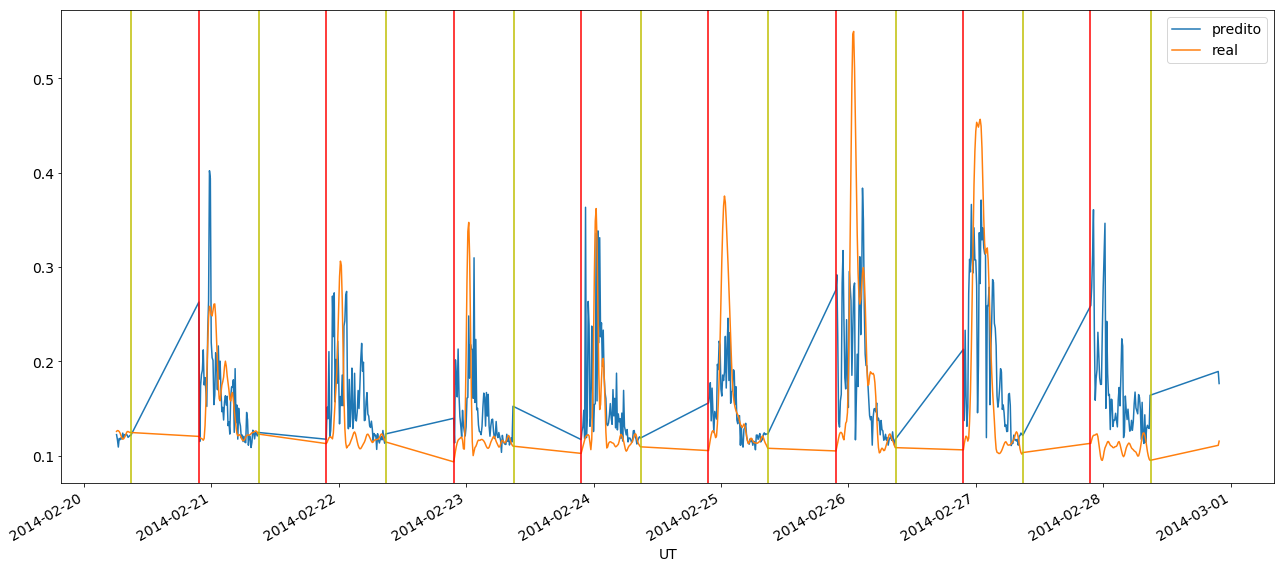


21  ->  vtec + gvtec1 + gvtec2
Error for the time series sample:
acc             0.834103
f1              0.359230
far             0.536404
fn             62.800000
fp             30.600000
kappa           0.090410
me              0.365664
mse             0.005531
pod             0.294382
precission      0.463596
re             24.110567
recall          0.294382
tn            443.400000
tp             26.200000
tse             1.764392
dtype: float64


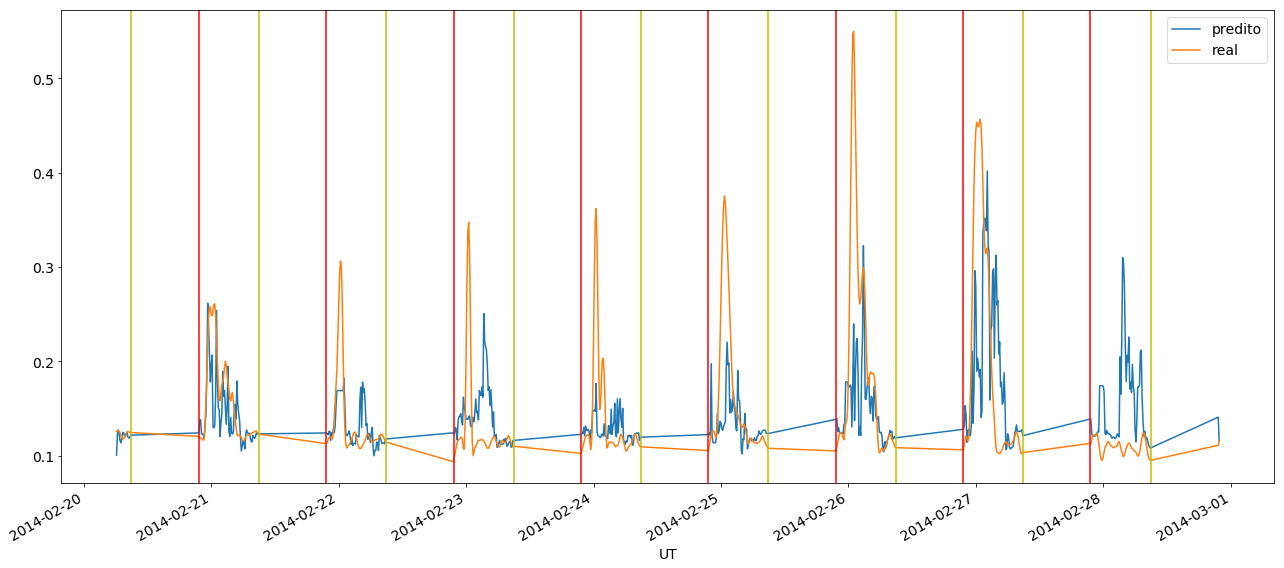


22  ->  vtec + tempo
Error for the time series sample:
acc             0.784014
f1              0.378092
far             0.653155
fn             51.900000
fp             69.700000
kappa           0.074449
me              0.354555
mse             0.006867
pod             0.416854
precission      0.346845
re             32.058508
recall          0.416854
tn            404.300000
tp             37.100000
tse             1.965782
dtype: float64


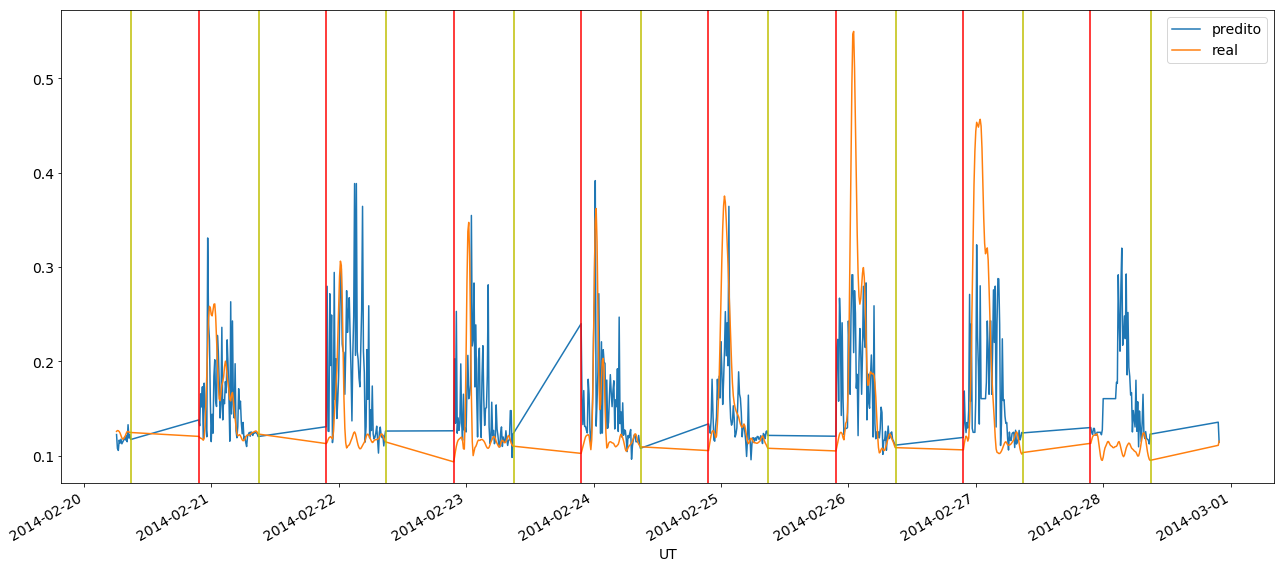


23  ->  vtec + tempo + mdv1
Error for the time series sample:
acc             0.780639
f1              0.466773
far             0.619340
fn             34.900000
fp             88.600000
kappa           0.057806
me              0.307211
mse             0.009276
pod             0.607865
precission      0.380660
re             40.202860
recall          0.607865
tn            385.400000
tp             54.100000
tse             2.282439
dtype: float64


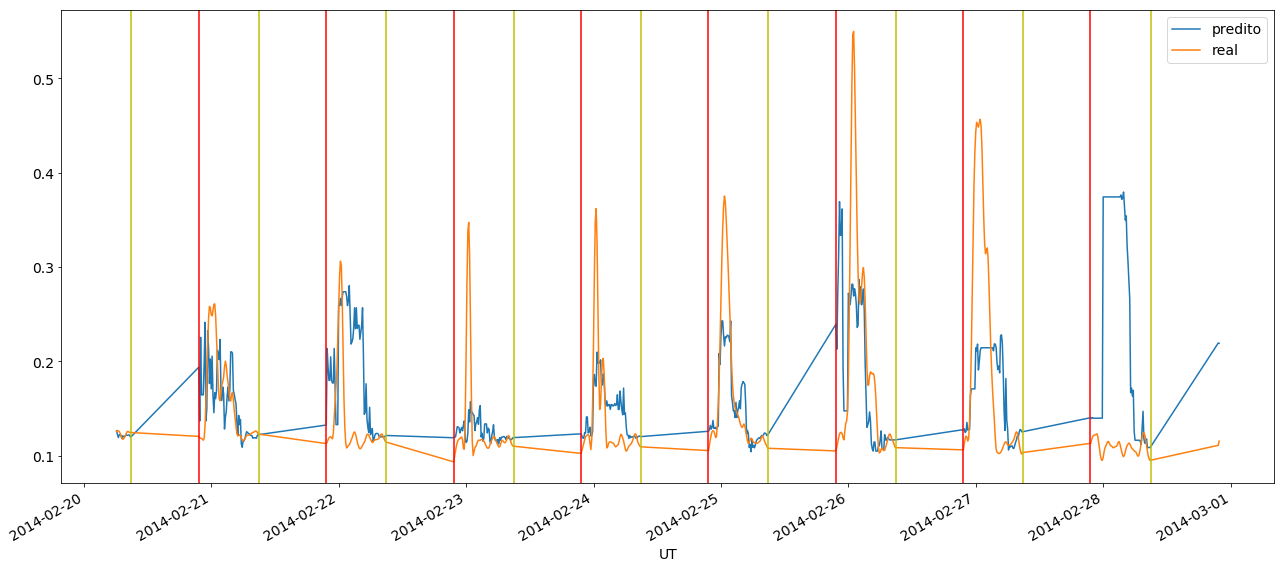


24  ->  vtec + tempo + lag
Error for the time series sample:
acc             0.821314
f1              0.537344
far             0.544944
fn             30.600000
fp             70.000000
kappa           0.051854
me              0.305086
mse             0.004737
pod             0.656180
precission      0.455056
re             29.233333
recall          0.656180
tn            404.000000
tp             58.400000
tse             1.631873
dtype: float64


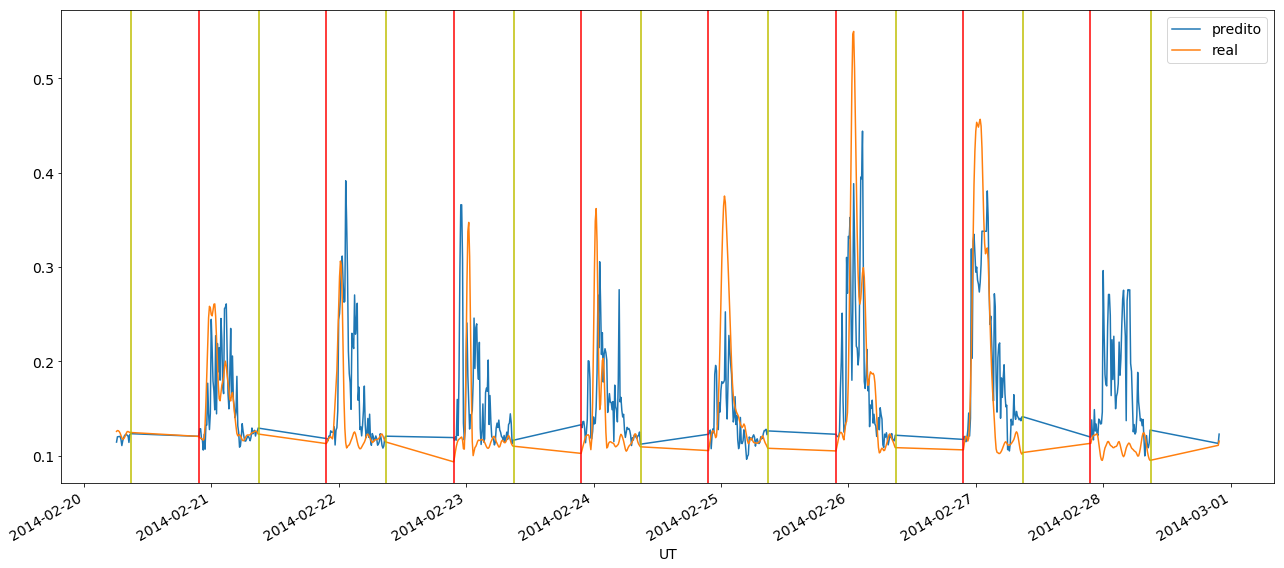


25  ->  vtec + tempo + lag + mdv1
Error for the time series sample:
acc             0.790409
f1              0.529619
far             0.589562
fn             22.500000
fp             95.500000
kappa           0.046959
me              0.315356
mse             0.007246
pod             0.747191
precission      0.410438
re             35.920716
recall          0.747191
tn            378.500000
tp             66.500000
tse             2.017311
dtype: float64


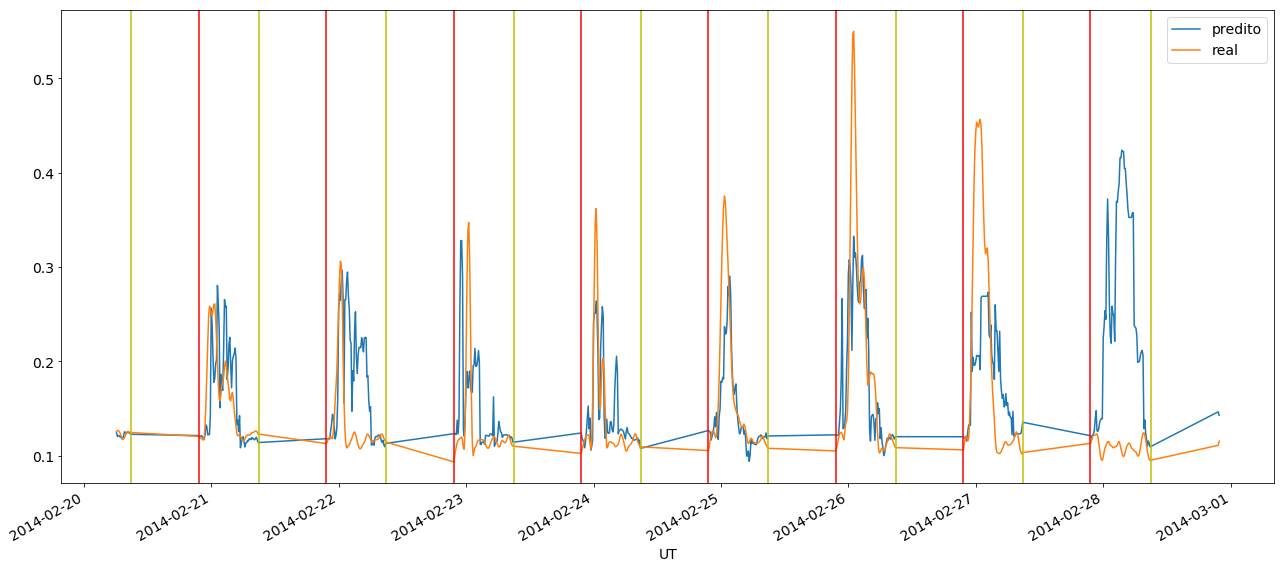


26  ->  vtec + tempo + lag + mdv2
Error for the time series sample:
acc             0.794671
f1              0.415108
far             0.615808
fn             47.900000
fp             67.700000
kappa           0.070409
me              0.305732
mse             0.005249
pod             0.461798
precission      0.384192
re             29.899316
recall          0.461798
tn            406.300000
tp             41.100000
tse             1.717959
dtype: float64


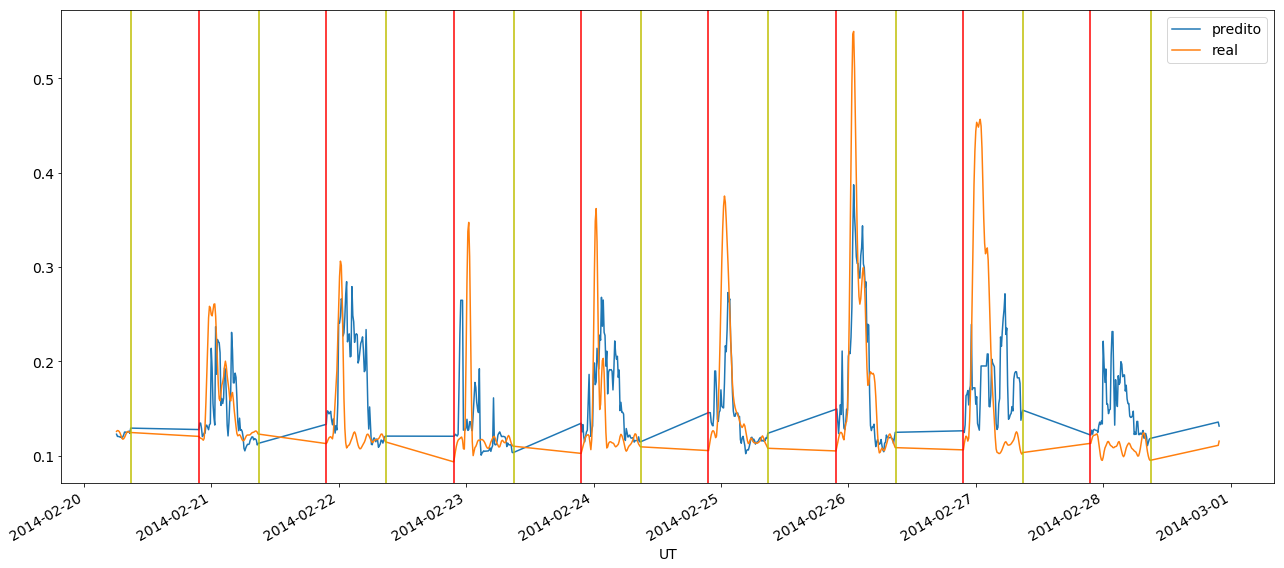


27  ->  vtec + tempo + lag + mdv1 + mdv2
Error for the time series sample:
acc             0.775844
f1              0.497950
far             0.613746
fn             26.500000
fp             99.700000
kappa           0.051002
me              0.301991
mse             0.006989
pod             0.702247
precission      0.386254
re             37.855547
recall          0.702247
tn            374.300000
tp             62.500000
tse             1.981398
dtype: float64


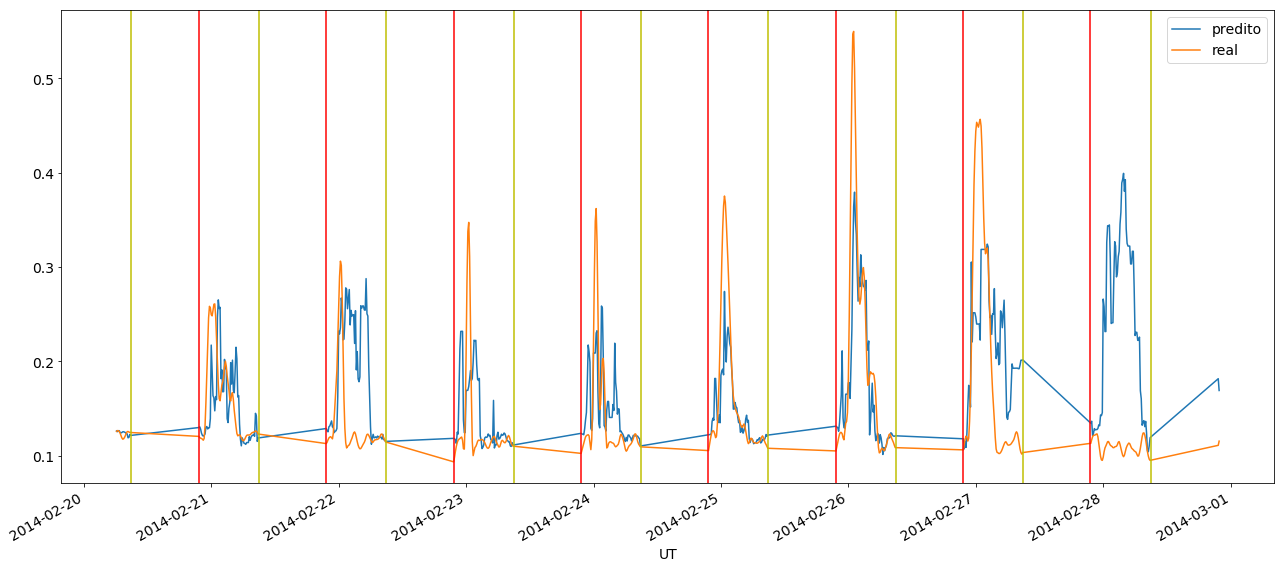

In [7]:
with open('./data/result/09_analise_all_cut_0_5.txt', 'w') as file:
    errors = []
    for idx, i in enumerate(set_tests):
        print(idx,' -> ', i.name)
        if param_grid is not None:
            if idx != 0:
                file.write('\n')
            file.write(idx+' -> '+i.name+'\n')
        dict_error = generate_and_avaliate_model(df=df,
                                                instances_set=list(i.set),
                                                target='s4',
                                                save=True,
                                                grid_search=True,
                                                file_to_save_model='./images/09_analise_all_cut_0_5/' + i.name + '.eps ',
                                                cut_value=0.5,
                                                file=file)
        dict_error['name'] = i.name
        errors.append(dict_error)
        print()

In [8]:
df = pd.DataFrame(errors) 
df.index = df['name']
del df['name']
df = df[['tp', 'tn', 'fp', 'fn', 're', 'pod', 'far', 'acc', 'precission', 'recall', 'f1', 'kappa', 'me', 'tse', 'mse']]
pd.set_option('precision', 4)

In [9]:
with open('./data/result/09_analise_all_cut_0_5.txt', 'a') as file:
    file.write(df.to_string())